<a href="https://colab.research.google.com/github/tngym/workrepo/blob/master/irm/20200515_rex_cmnist_1restart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# https://github.com/capybaralet/REx_code_release/blob/802da4a45a92a1f7f2c50cb1aecf5a195ef65435/InvariantRiskMinimization/colored_mnist/main.py

import argparse
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torch import nn, optim, autograd


def str2bool(v):
  return v.lower() in ("yes", "true", "t", "1")

use_cuda = torch.cuda.is_available()

parser = argparse.ArgumentParser(description='Colored MNIST')
parser.add_argument('--hidden_dim', type=int, default=256)
parser.add_argument('--l2_regularizer_weight', type=float,default=0.001)
parser.add_argument('--lr', type=float, default=0.001)
parser.add_argument('--n_restarts', type=int, default=10)
parser.add_argument('--penalty_anneal_iters', type=int, default=100)
parser.add_argument('--penalty_weight', type=float, default=10000.0)
parser.add_argument('--steps', type=int, default=501)
parser.add_argument('--grayscale_model', type=str2bool, default=False)
parser.add_argument('--batch_size', type=int, default=25000)
parser.add_argument('--train_set_size', type=int, default=50000)
parser.add_argument('--eval_interval', type=int, default=100)
parser.add_argument('--print_eval_intervals', type=str2bool, default=True)

parser.add_argument('--train_env_1__color_noise', type=float, default=0.2)
parser.add_argument('--train_env_2__color_noise', type=float, default=0.1)
#parser.add_argument('--val_env__color_noise', type=float, default=0.1)
parser.add_argument('--test_env__color_noise', type=float, default=0.9)

parser.add_argument('--erm_amount', type=float, default=1.0)

parser.add_argument('--early_loss_mean', type=str2bool, default=True)

parser.add_argument('--rex', type=str2bool, default=True)
parser.add_argument('--mse', type=str2bool, default=True)

parser.add_argument('--plot', type=str2bool, default=True)
parser.add_argument('--save_numpy_log', type=str2bool, default=True)


_StoreAction(option_strings=['--save_numpy_log'], dest='save_numpy_log', nargs=None, const=None, default=True, type=<function str2bool at 0x7f50b1d62d90>, choices=None, help=None, metavar=None)

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline

In [33]:
flags = parser.parse_args([])

print('Flags:')
for k,v in sorted(vars(flags).items()):
  print("\t{}: {}".format(k, v))

num_batches = (flags.train_set_size // 2) // flags.batch_size

# TODO: logging
all_train_nlls = -1*np.ones((flags.n_restarts, flags.steps))
all_train_accs = -1*np.ones((flags.n_restarts, flags.steps))
#all_train_penalties = -1*np.ones((flags.n_restarts, flags.steps))
all_irmv1_penalties = -1*np.ones((flags.n_restarts, flags.steps))
all_rex_penalties = -1*np.ones((flags.n_restarts, flags.steps))
all_test_accs = -1*np.ones((flags.n_restarts, flags.steps))
all_grayscale_test_accs = -1*np.ones((flags.n_restarts, flags.steps))

final_train_accs = []
final_test_accs = []
highest_test_accs = []

Flags:
	batch_size: 25000
	early_loss_mean: True
	erm_amount: 1.0
	eval_interval: 100
	grayscale_model: False
	hidden_dim: 256
	l2_regularizer_weight: 0.001
	lr: 0.001
	mse: True
	n_restarts: 10
	penalty_anneal_iters: 100
	penalty_weight: 10000.0
	plot: True
	print_eval_intervals: True
	rex: True
	save_numpy_log: True
	steps: 501
	test_env__color_noise: 0.9
	train_env_1__color_noise: 0.2
	train_env_2__color_noise: 0.1
	train_set_size: 50000


In [0]:
restart = 0

In [0]:
highest_test_acc = 0.0

# Load MNIST, make train/val splits, and shuffle train set examples

mnist = datasets.MNIST('~/datasets/mnist', train=True, download=True)
mnist_train = (mnist.data[:50000], mnist.targets[:50000])
mnist_val = (mnist.data[50000:], mnist.targets[50000:])

rng_state = np.random.get_state()
np.random.shuffle(mnist_train[0].numpy())
np.random.set_state(rng_state)
np.random.shuffle(mnist_train[1].numpy())

In [0]:
# Build environments

def make_environment(images, labels, e, grayscale_dup=False):
  def torch_bernoulli(p, size):
    return (torch.rand(size) < p).float()
  def torch_xor(a, b):
    return (a-b).abs() # Assumes both inputs are either 0 or 1
  # 2x subsample for computational convenience
  images = images.reshape((-1, 28, 28))[:, ::2, ::2]
  # Assign a binary label based on the digit; flip label with probability 0.25
  labels = (labels < 5).float()
  labels = torch_xor(labels, torch_bernoulli(.25, len(labels)))
  # Assign a color based on the label; flip the color with probability e
  colors = torch_xor(labels, torch_bernoulli(e, len(labels)))
  # Apply the color to the image by zeroing out the other color channel
  images = torch.stack([images, images], dim=1)
  if not grayscale_dup:
    images[torch.tensor(range(len(images))), (1-colors).long(), :, :] *= 0
  if use_cuda:
    return {
      'images': (images.float() / 255.).cuda(),
      'labels': labels[:, None].cuda()
    }
  else:
    return {
      'images': (images.float() / 255.),
      'labels': labels[:, None]
    }

envs = [
  make_environment(mnist_train[0][::2], mnist_train[1][::2], flags.train_env_1__color_noise),
  make_environment(mnist_train[0][1::2], mnist_train[1][1::2], flags.train_env_2__color_noise),
  make_environment(mnist_val[0], mnist_val[1], flags.test_env__color_noise),
  make_environment(mnist_val[0], mnist_val[1], flags.test_env__color_noise, grayscale_dup=True)
]  


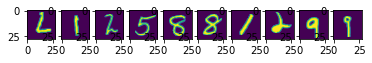

In [37]:
fig, axs = plt.subplots(1, 10, figsize = (6, 6))
for i in range(10):
  axs[i].imshow(mnist_train[0][i].numpy())

env: 0, label: 1.0


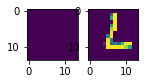

env: 0, label: 1.0


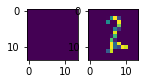

env: 0, label: 0.0


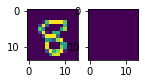

env: 0, label: 0.0


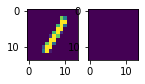

env: 0, label: 0.0


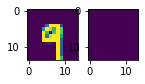

env: 0, label: 1.0


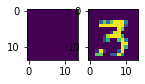

env: 0, label: 0.0


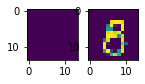

env: 0, label: 1.0


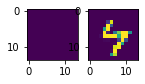

env: 0, label: 1.0


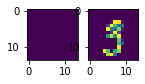

env: 0, label: 0.0


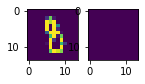

env: 1, label: 1.0


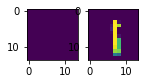

env: 1, label: 0.0


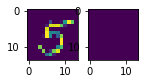

env: 1, label: 0.0


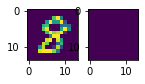

env: 1, label: 1.0


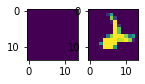

env: 1, label: 0.0


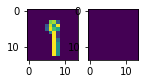

env: 1, label: 1.0


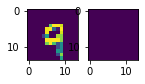

env: 1, label: 1.0


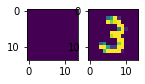

env: 1, label: 1.0


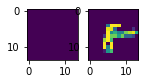

env: 1, label: 1.0


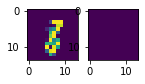

env: 1, label: 1.0


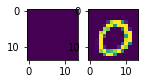

env: 2, label: 1.0


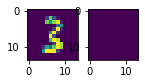

env: 3, label: 1.0


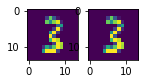

env: 2, label: 0.0


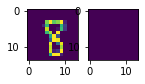

env: 3, label: 0.0


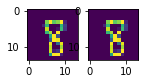

env: 2, label: 0.0


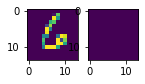

env: 3, label: 0.0


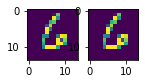

env: 2, label: 0.0


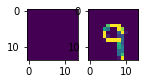

env: 3, label: 0.0


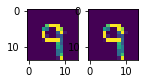

env: 2, label: 1.0


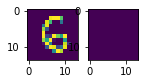

env: 3, label: 0.0


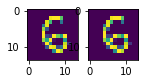

env: 2, label: 1.0


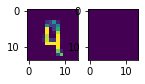

env: 3, label: 1.0


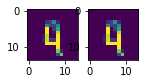

env: 2, label: 0.0


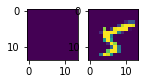

env: 3, label: 0.0


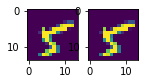

env: 2, label: 1.0


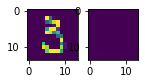

env: 3, label: 1.0


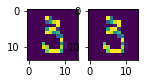

env: 2, label: 0.0


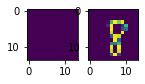

env: 3, label: 0.0


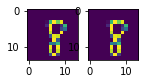

env: 2, label: 1.0


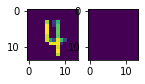

env: 3, label: 1.0


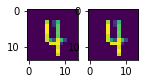

In [38]:
def _show(img_id, env_id):
  print(f"env: {env_id}, label: {envs[env_id]['labels'][img_id][0]}")
  fig, axs = plt.subplots(1, 2, figsize = (2, 2))
  axs[0].imshow(envs[env_id]["images"][img_id][0].cpu().numpy())
  axs[1].imshow(envs[env_id]["images"][img_id][1].cpu().numpy())
  plt.show();

for j in range(2):
  for i in range(10):
    _show(i, j)

for i in range(10):
  for j in range(2, 4):
    _show(i, j)

In [0]:

# Define and instantiate the model

class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    if flags.grayscale_model:
      lin1 = nn.Linear(14 * 14, flags.hidden_dim)
    else:
      lin1 = nn.Linear(2 * 14 * 14, flags.hidden_dim)
    lin2 = nn.Linear(flags.hidden_dim, flags.hidden_dim)
    lin3 = nn.Linear(flags.hidden_dim, 1)
    for lin in [lin1, lin2, lin3]:
      nn.init.xavier_uniform_(lin.weight)
      nn.init.zeros_(lin.bias)
    self._main = nn.Sequential(lin1, nn.ReLU(True), lin2, nn.ReLU(True), lin3)
  def forward(self, input):
    if flags.grayscale_model:
      out = input.view(input.shape[0], 2, 14 * 14).sum(dim=1)
    else:
      out = input.view(input.shape[0], 2 * 14 * 14)
    out = self._main(out)
    return out

if use_cuda:
  mlp = MLP().cuda()
else:
  mlp = MLP()

ここでは IRM のペナルティのみ定義．REx のペナルティは学習部分で

In [0]:
# Define loss function helpers

def mean_nll(logits, y):
  return nn.functional.binary_cross_entropy_with_logits(logits, y)

def mean_accuracy(logits, y):
  preds = (logits > 0.).float()
  return ((preds - y).abs() < 1e-2).float().mean()

def penalty(logits, y):
  if use_cuda:
    scale = torch.tensor(1.).cuda().requires_grad_()
  else:
    scale = torch.tensor(1.).requires_grad_()
  loss = mean_nll(logits * scale, y)
  grad = autograd.grad(loss, [scale], create_graph=True)[0]
  return torch.sum(grad**2)

In [41]:
# Train loop
def pretty_print(*values):
  col_width = 13
  def format_val(v):
    if not isinstance(v, str):
      v = np.array2string(v, precision=5, floatmode='fixed')
    return v.ljust(col_width)
  str_values = [format_val(v) for v in values]
  print("   ".join(str_values))

optimizer = optim.Adam(mlp.parameters(), lr=flags.lr)

pretty_print('step', 'train nll', 'train acc', 'rex penalty', 'irmv1 penalty', 'test acc')

i = 0
for step in range(flags.steps):
  n = i % num_batches
  for edx, env in enumerate(envs):
    if edx != len(envs) - 2:
      logits = mlp(env['images'][n*flags.batch_size:(n+1)*flags.batch_size])
      env['nll'] = mean_nll(logits, env['labels'][n*flags.batch_size:(n+1)*flags.batch_size])
      env['acc'] = mean_accuracy(logits, env['labels'][n*flags.batch_size:(n+1)*flags.batch_size])
      env['penalty'] = penalty(logits, env['labels'][n*flags.batch_size:(n+1)*flags.batch_size])
    else:
      # validation data に対してはこちら
      logits = mlp(env['images'])
      env['nll'] = mean_nll(logits, env['labels'])
      env['acc'] = mean_accuracy(logits, env['labels'])
      env['penalty'] = penalty(logits, env['labels'])
  i+=1

  # training data は envs[0] と envs[1]
  train_nll = torch.stack([envs[0]['nll'], envs[1]['nll']]).mean()
  train_acc = torch.stack([envs[0]['acc'], envs[1]['acc']]).mean()
  irmv1_penalty = torch.stack([envs[0]['penalty'], envs[1]['penalty']]).mean()

  if use_cuda:
    weight_norm = torch.tensor(0.).cuda()
  else:
    weight_norm = torch.tensor(0.)
  for w in mlp.parameters():
    weight_norm += w.norm().pow(2)

  loss1 = envs[0]['nll']
  loss2 = envs[1]['nll']

  if flags.early_loss_mean:
    loss1 = loss1.mean()
    loss2 = loss2.mean()

  loss = 0.0
  loss += flags.erm_amount * (loss1 + loss2)          # Loss の第一項: ERM term

  loss += flags.l2_regularizer_weight * weight_norm   # Loss の第二項：weight regularization

  penalty_weight = (flags.penalty_weight              # penalty 項は最初はすごく小さく途中から大きくする
    if step >= flags.penalty_anneal_iters else 1.0)   # この重みは IRM/MinREx/VarREx 共通

  if flags.mse:
    rex_penalty = (loss1.mean() - loss2.mean()) ** 2  # Minimax REx
  else:
    rex_penalty = (loss1.mean() - loss2.mean()).abs() # Variance REx

  if flags.rex:
    loss += penalty_weight * rex_penalty
  else:
    loss += penalty_weight * irmv1_penalty

  if penalty_weight > 1.0:                            # penalty weight >=1 なので if がなくても同じ
    # Rescale the entire loss to keep gradients in a reasonable range
    loss /= penalty_weight

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  
  test_acc = envs[2]['acc']
  grayscale_test_acc = envs[3]['acc']

  # 以下はただ記録を保持するだけ
  if step % flags.eval_interval == 0:
    train_acc_scalar = train_acc.detach().cpu().numpy()
    test_acc_scalar = test_acc.detach().cpu().numpy()
    if flags.print_eval_intervals:
      # ここで print する
      pretty_print(
        np.int32(step),
        train_nll.detach().cpu().numpy(),
        train_acc.detach().cpu().numpy(),
        rex_penalty.detach().cpu().numpy(),
        irmv1_penalty.detach().cpu().numpy(),
        test_acc.detach().cpu().numpy()
      )
    if (train_acc_scalar >= test_acc_scalar) and (test_acc_scalar > highest_test_acc):
      highest_test_acc = test_acc_scalar

  if flags.plot or flags.save_numpy_log:
    all_train_nlls[restart, step] = train_nll.detach().cpu().numpy()
    all_train_accs[restart, step] = train_acc.detach().cpu().numpy()
    all_rex_penalties[restart, step] = rex_penalty.detach().cpu().numpy()
    all_irmv1_penalties[restart, step] = irmv1_penalty.detach().cpu().numpy()
    all_test_accs[restart, step] = test_acc.detach().cpu().numpy()
    all_grayscale_test_accs[restart, step] = grayscale_test_acc.detach().cpu().numpy()


step            train nll       train acc       rex penalty     irmv1 penalty   test acc     
0               0.69067         0.50612         4.57163e-06     1.07385e-05     0.48830      
100             0.36432         0.85030         0.01545         0.00392         0.11430      
200             0.56876         0.71908         5.31564e-07     0.00105         0.68400      
300             0.56717         0.72090         1.19184e-07     0.00116         0.68530      
400             0.56402         0.72282         1.17871e-07     0.00135         0.68440      
500             0.56068         0.72476         1.14659e-07     0.00154         0.68280      


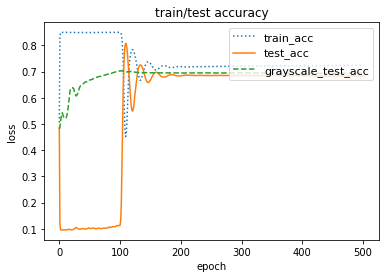

In [45]:
plot_x = np.linspace(0, flags.steps, flags.steps)
from pylab import *

figure()
xlabel('epoch')
ylabel('loss')
title('train/test accuracy')
# 元のコードは平均をとっているが今回は restart を 10 回分とっていないことに注意
plot(plot_x, all_train_accs[0], ls="dotted", label='train_acc')
plot(plot_x, all_test_accs[0], label='test_acc')
plot(plot_x, all_grayscale_test_accs[0], ls="--", label='grayscale_test_acc')
legend(prop={'size': 11}, loc="upper right")
savefig('train_acc__test_acc.pdf')